# Antenna Rescaler

In [1]:
import timeit
from nec_model import *
from nec_cards import *
from show_model import *       
from IPython.display import display, HTML

## Rescaling Function

The script below performs the following steps:

- load the antenna model from the NEC cards;
- use the NEC2 engine to evaluate the characteristics of the antenna, print the values and plot the charts;
- find the frequency with the highest return loss and rescale the antenna from that frequency to the desired frequency by scaling all antenna dimensions;
- rescale the wire radius using the DG7YBN [manual rescaling procedure](http://dg7ybn.de/Scaling/Scaling_Yagis.htm), implemented in the code:
  - change the wire radius, one element at a time;
  - after each change adjust the wire length to bring the RL, F/B and gain back to their original values;
  - start with the furtherst director and move towards the reflector, excluding DE;
- print / plot the characteristics after the frequency and radius rescale;
- print the modified NEC cards and save them to a .nec file.

The procedure has been tested on the [GTV antennas](http://dg7ybn.de/144MHz/144_Ant.htm) by DG7YBN.

The radius scaling function takes the radius of the first wire in the model as `from_radius`, and scales all wires that have that radius to the desired new value. The wires with a different radius are not scaled, to exclude the DE which in the GTV model consists of three wires, so re-scaling them would require special care to keep them connected to each other.

**Edit:** 

- `from_frequency` in frequency re-scailing is now set to the design frequency (FR card in the model) instead of the best RL frequency;
- the optimization procedure used to re-scale the element radius has been modified to adjust both element length and its location on the boom. As a result, the re-scaled antenna parameters are within 0.01 dB of  the original values.

In [2]:
def show(nec, frequencies):
    nec.build_model()
    characteristics = nec.compute_characteristics()
    sweep = nec.sweep_frequency(frequencies)
    show_model(nec, characteristics, sweep)
    return sweep
    

def rescale_model(nec_file, frequencies, new_freq, new_radius, out_file_path):
    # load model
    display(HTML('<hr><h4>Original Model:</h4><br>'))
    nec = NecModel()
    nec.from_text(nec_file)    
    sweep = show(nec, frequencies)    
    
    # scale freq
    display(HTML('<hr><h4>Rescaled Frequency:</h4>'))
    print(f"\nRescaled frequency to {new_freq:.3f} MHz:\n")
    # old_freq = sweep.freq_of_max
    old_freq = nec.fr_cards[0].frequency
    nec.rescale_frequency(old_freq, new_freq)
    show(nec, frequencies)
    
    # scale radius
    display(HTML('<hr><h4>Rescaled Radius:\n</h4>'))
    print(f"\nRescaled radius from {nec.gw_cards[0].radius * 1000:.3f} mm to {new_radius * 1000:.3f} mm:\n")
    start_time = timeit.default_timer()
    nec.rescale_radius(nec.gw_cards[0].radius, new_radius)
    print(f"Time elapsed: {timeit.default_timer() - start_time:.1f} s\n")
    show(nec, frequencies)

    display(HTML('<hr><h4>Modified Model:</h4><br>'))
    nec.cm_cards.append(f"Re-scaled to frequency {new_freq:.3f} MHz and {new_radius * 1000:.3f} mm radius")
    print (nec.to_text())
    display(HTML('<hr>'))
    nec.save_to_file(out_file_path)

## Rescale VHF Antenna

f    = 144.1 MHz
z    = 49.82+2.30j Ohms
Г    = -0.001+0.023j
RL   = 32.74 dB
SWR  = 1.047
gain = 11.90 dB
F/B  = 30.98 dB
Max. RL = 40.10 dB at 144.25 MHz


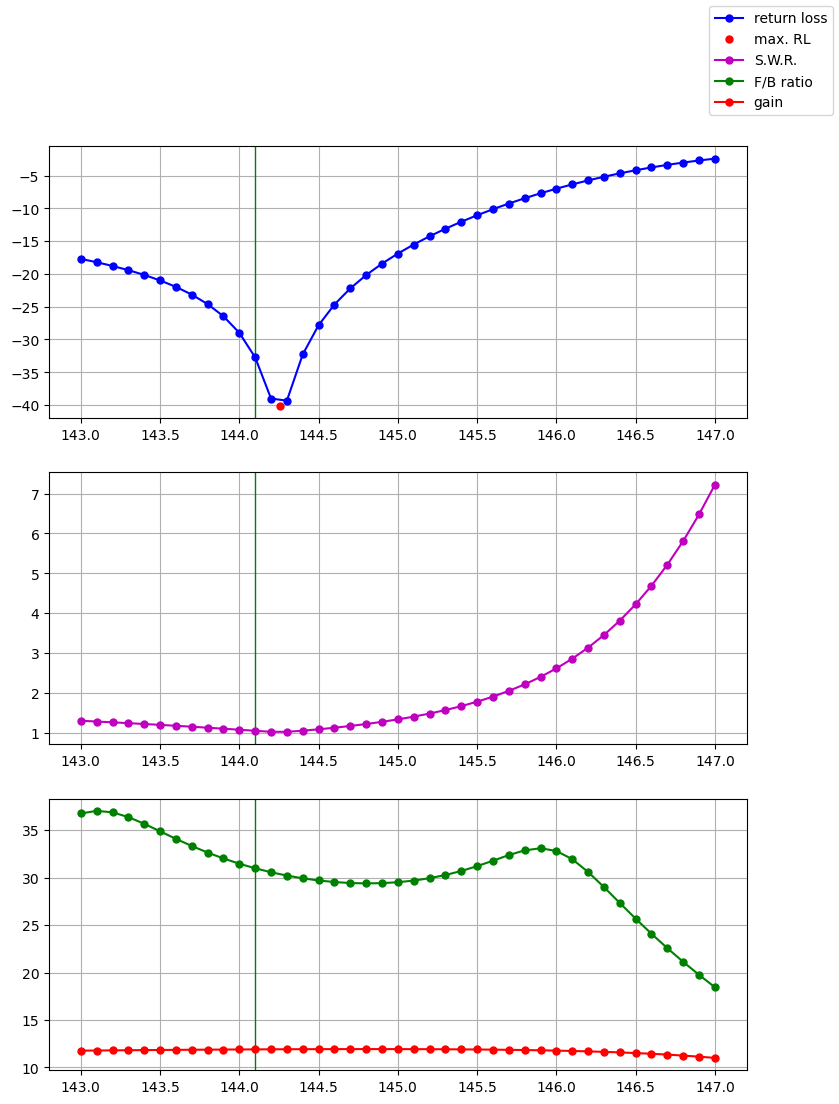

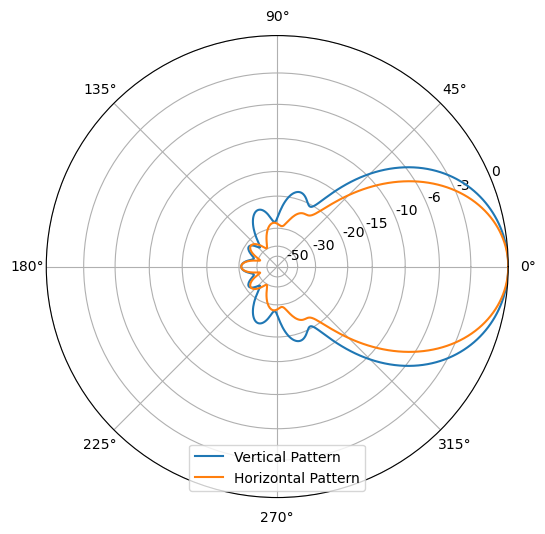


Rescaled frequency to 145.900 MHz:

f    = 145.9 MHz
z    = 49.82+2.29j Ohms
Г    = -0.001+0.023j
RL   = 32.75 dB
SWR  = 1.047
gain = 11.90 dB
F/B  = 30.98 dB
Max. RL = 40.22 dB at 146.06 MHz


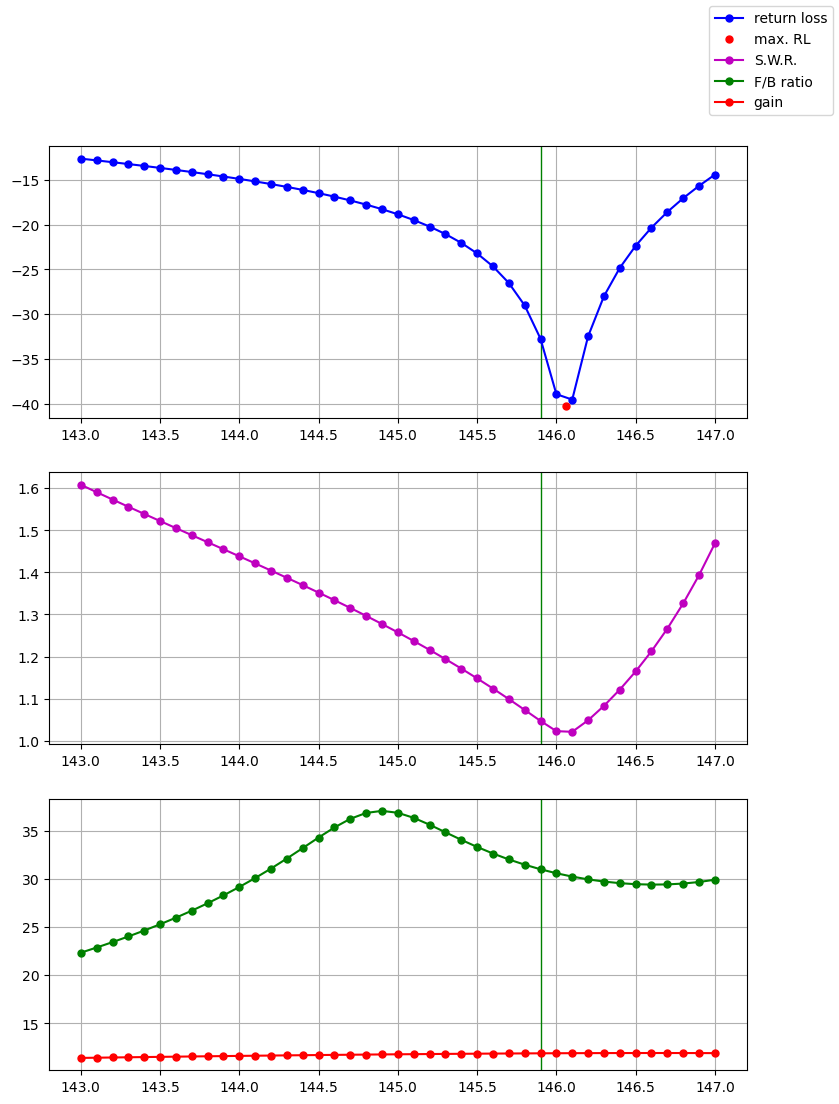

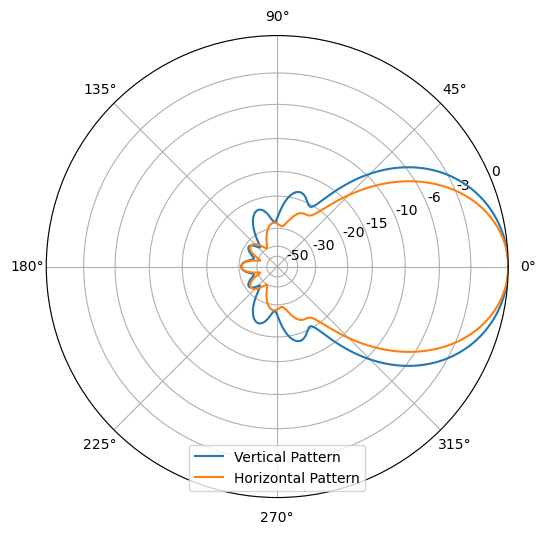


Rescaled radius from 3.951 mm to 3.175 mm:

Time elapsed: 22.5 s

f    = 145.9 MHz
z    = 50.52+2.26j Ohms
Г    = 0.006+0.022j
RL   = 32.75 dB
SWR  = 1.047
gain = 11.89 dB
F/B  = 30.98 dB
Max. RL = 36.91 dB at 146.02 MHz


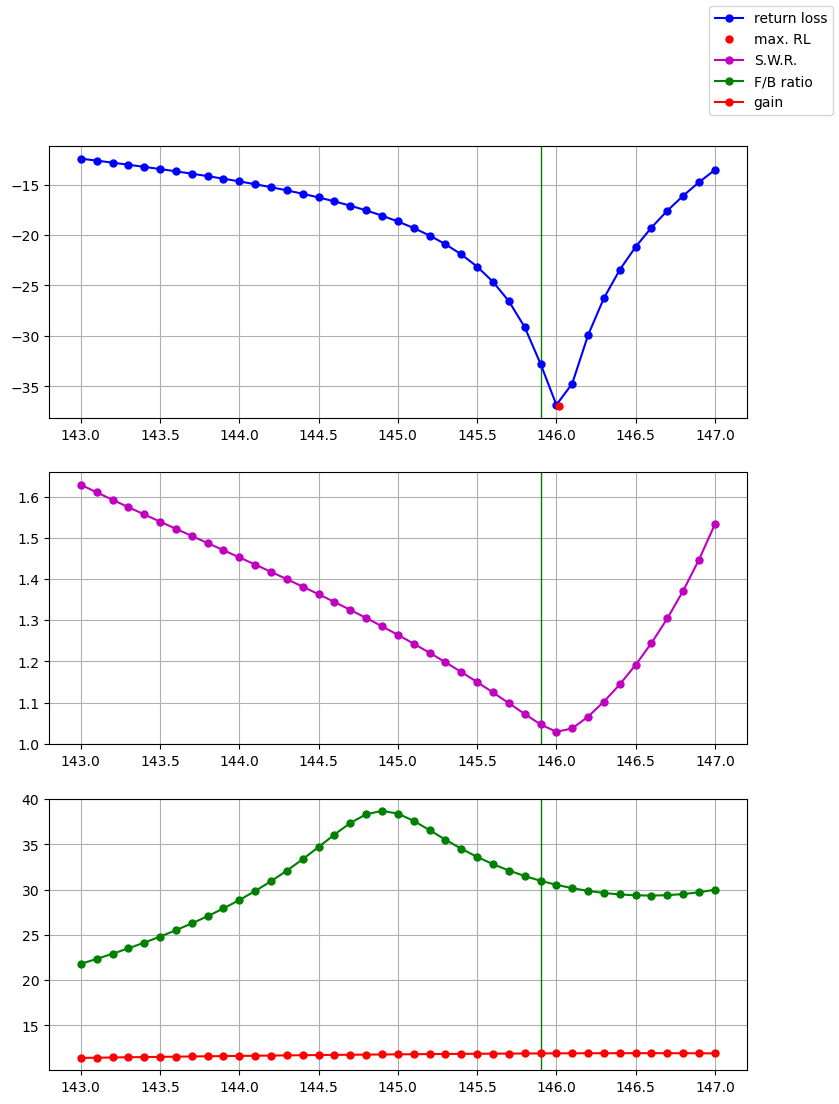

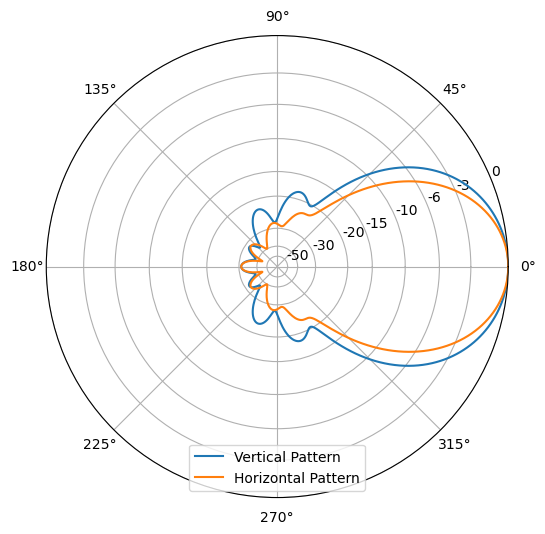

CM GTV 2-6m temp, converted with 4nec2 on 2-May-25 10:43
CM Re-scaled to frequency 145.900 MHz and 3.175 mm radius
CE
GW 1 26 0.00014 0.49721 0.00000 0.00014 -0.49721 0.00000 0.003175
GW 2 11 0.27161 -0.09877 0.00000 0.18568 -0.47605 0.00000 0.004938
GW 3 11 0.27161 0.09877 0.00000 0.18568 0.47605 0.00000 0.004938
GW 4 7 0.27161 0.09877 0.00000 0.27161 -0.09877 0.00000 0.004938
GW 5 25 0.51457 0.47468 0.00000 0.51457 -0.47468 0.00000 0.003175
GW 6 24 0.95593 0.46156 0.00000 0.95593 -0.46156 0.00000 0.003175
GW 7 23 1.63966 0.44811 0.00000 1.63966 -0.44811 0.00000 0.003175
GW 8 22 2.32898 0.41927 0.00000 2.32898 -0.41927 0.00000 0.003175
GE
LD 5 1 0 0 25000000.0 0
LD 5 2 0 0 25000000.0 0
LD 5 3 0 0 25000000.0 0
LD 5 4 0 0 25000000.0 0
LD 5 5 0 0 25000000.0 0
LD 5 6 0 0 25000000.0 0
LD 5 7 0 0 25000000.0 0
LD 5 8 0 0 25000000.0 0
EX 0 4 4 0 1.0 0.0
GN -1
FR 0 1 0 0 145.9 0


In [3]:
# define the original model.
# feel free to replace it with your own one
original_nec_file = """
CM GTV 2-6m temp, converted with 4nec2 on 2-May-25 10:43
CE
GW	1	26	0	0.502	0	0	-0.502	0	4.e-3
GW	2	11	0.275	-0.1	0	0.188	-0.482	0	5.e-3
GW	3	11	0.275	0.1	0	0.188	0.482	0	5.e-3
GW	4	7	0.275	0.1	0	0.275	-0.1	0	5.e-3
GW	5	25	0.521	0.478	0	0.521	-0.478	0	4.e-3
GW	6	24	0.969	0.464	0	0.969	-0.464	0	4.e-3
GW	7	23	1.66	0.45	0	1.66	-0.45	0	4.e-3
GW	8	22	2.358	0.42	0	2.358	-0.42	0	4.e-3
GE	0
LD	5	1	0	0	2.5e7	0
LD	5	2	0	0	2.5e7	0
LD	5	3	0	0	2.5e7	0
LD	5	4	0	0	2.5e7	0
LD	5	5	0	0	2.5e7	0
LD	5	6	0	0	2.5e7	0
LD	5	7	0	0	2.5e7	0
LD	5	8	0	0	2.5e7	0
EX	6	4	4	0	1	0
GN	-1
FR	0	1	0	0	144.1	0
"""

# optionally add to see the effect of the cross boom and plate:

# cross-boom
# GW  9   50   1.1     0.7    0.7  1.1   2.5    2.5  18.e-3
# plate
# GW  9   5   1.3    -0.05  -0.05   1.3  0.05  0.05  50.e-3


new_freq = 145.9
new_radius = 25.4e-3 / 4 / 2   # ⌀1/4"
frequencies = list_frequencies(143, 147, 0.1)
out_file_path = r"C:\Ant\gtv2_6m_sat.nec"
                   
rescale_model(original_nec_file, frequencies, new_freq, new_radius, out_file_path)

## Rescale UHF Antenna

f    = 430 MHz
z    = 41.58-0.57j Ohms
Г    = -0.092-0.007j
RL   = 20.71 dB
SWR  = 1.203
gain = 15.59 dB
F/B  = 31.35 dB
Max. RL = 36.51 dB at 432.63 MHz


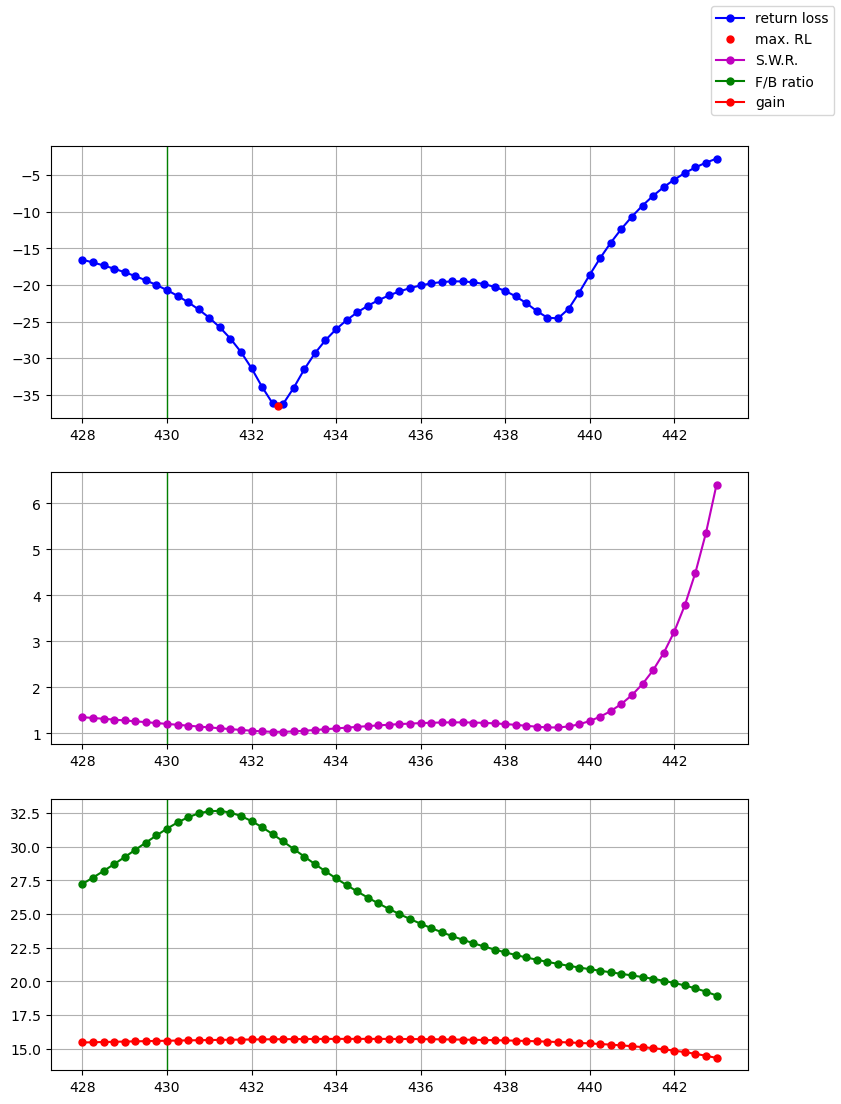

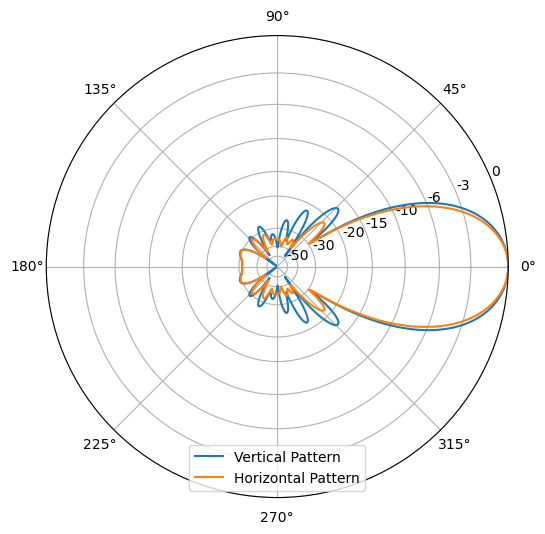


Rescaled frequency to 436.500 MHz:

f    = 436.5 MHz
z    = 41.58-0.57j Ohms
Г    = -0.092-0.007j
RL   = 20.71 dB
SWR  = 1.203
gain = 15.59 dB
F/B  = 31.35 dB
Max. RL = 36.55 dB at 439.18 MHz


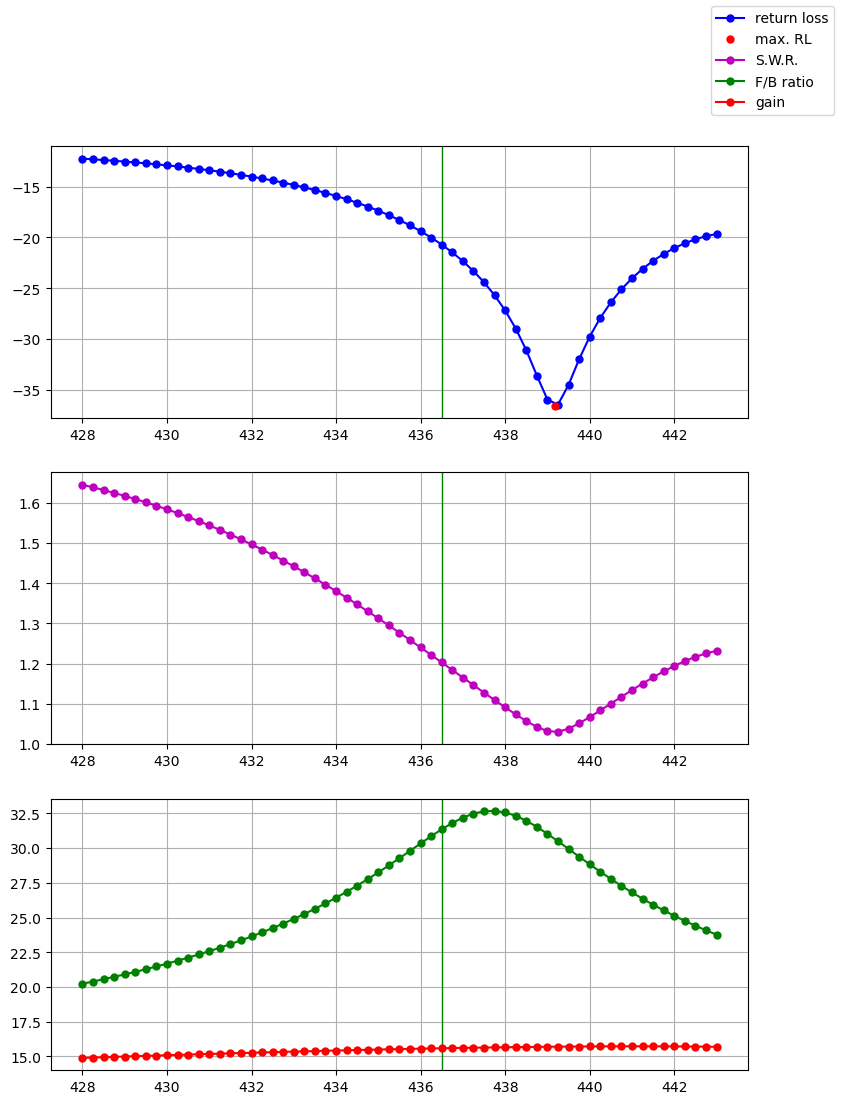

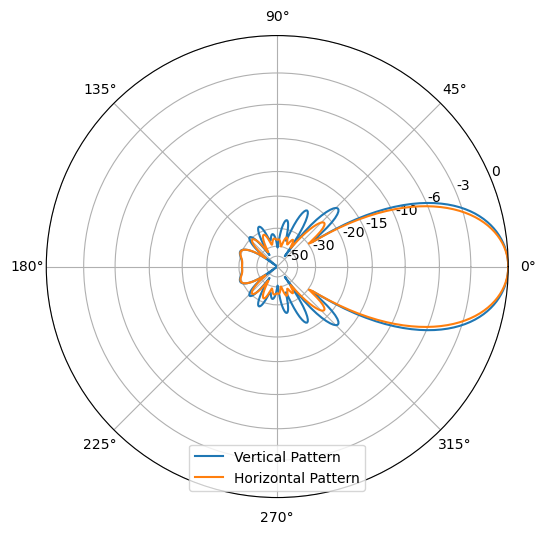


Rescaled radius from 1.970 mm to 3.175 mm:

Time elapsed: 122.1 s

f    = 436.5 MHz
z    = 41.56+0.03j Ohms
Г    = -0.092+0.000j
RL   = 20.71 dB
SWR  = 1.203
gain = 15.59 dB
F/B  = 31.35 dB
Max. RL = 43.75 dB at 438.98 MHz


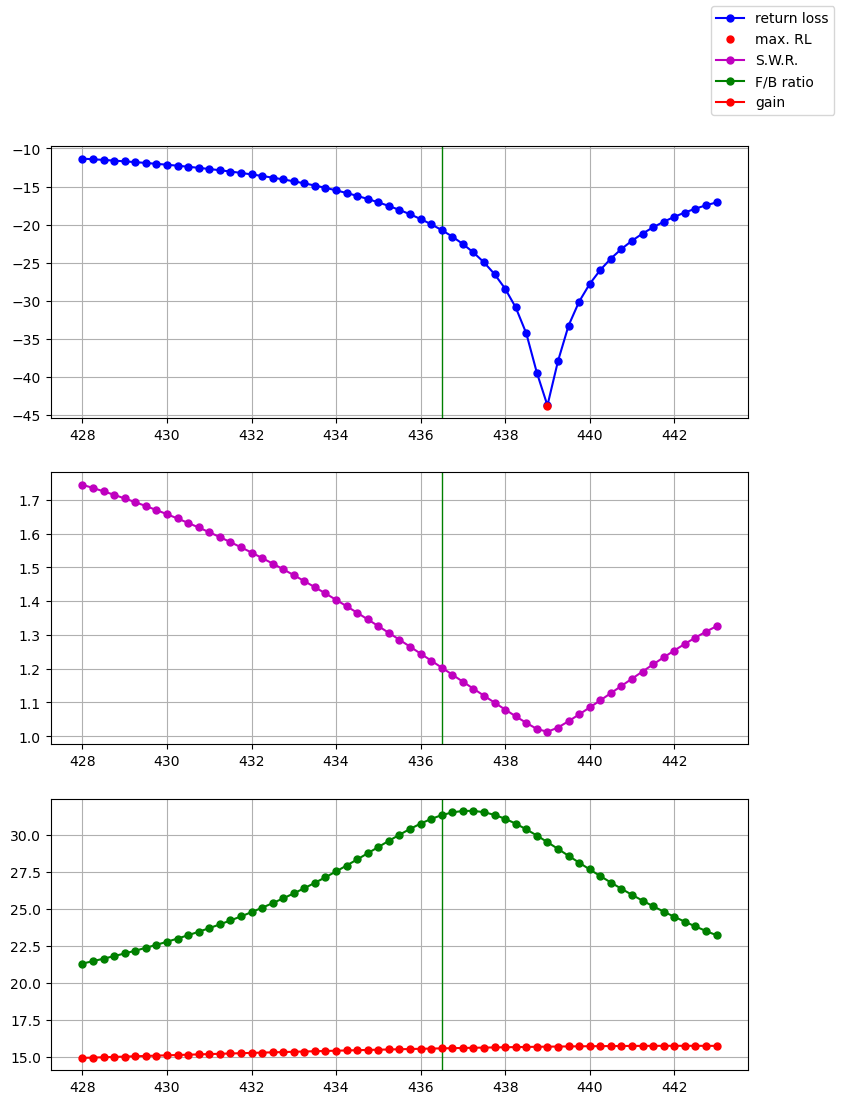

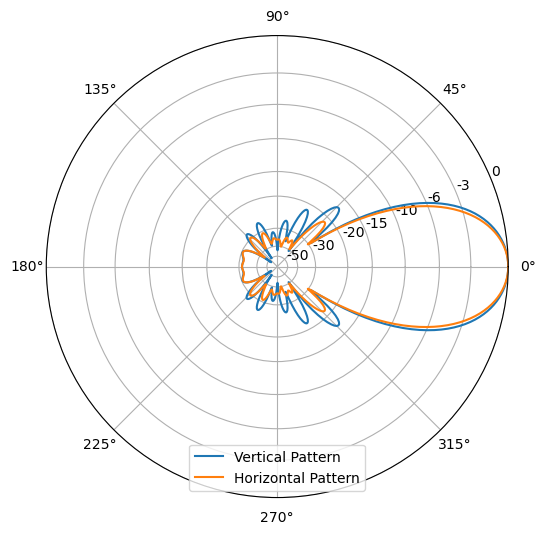

CM 13 ele 432 Mhz  OWA
CM Re-scaled to frequency 436.500 MHz and 3.175 mm radius
CE
GW 1 24 -0.00161 -0.16253 0.00000 -0.00161 0.16253 0.00000 0.003175
GW 2 10 0.10294 -0.03349 0.00000 0.08669 -0.15699 0.00000 0.004926
GW 3 10 0.10294 0.03349 0.00000 0.08669 0.15699 0.00000 0.004926
GW 4 5 0.10294 -0.03349 0.00000 0.10294 0.03349 0.00000 0.004926
GW 5 22 0.14829 -0.15346 0.00000 0.14829 0.15346 0.00000 0.003175
GW 6 22 0.24165 -0.15064 0.00000 0.24165 0.15064 0.00000 0.003175
GW 7 21 0.42400 -0.14511 0.00000 0.42400 0.14511 0.00000 0.003175
GW 8 20 0.64096 -0.14159 0.00000 0.64096 0.14159 0.00000 0.003175
GW 9 20 0.88757 -0.13984 0.00000 0.88757 0.13984 0.00000 0.003175
GW 10 20 1.14866 -0.13773 0.00000 1.14866 0.13773 0.00000 0.003175
GW 11 20 1.41564 -0.13613 0.00000 1.41564 0.13613 0.00000 0.003175
GW 12 19 1.68947 -0.13242 0.00000 1.68947 0.13144 0.00000 0.003175
GW 13 19 1.96338 -0.13142 0.00000 1.96338 0.13142 0.00000 0.003175
GW 14 19 2.21847 -0.12829 0.00000 2.21847 0.12829 0.0

In [4]:
original_nec_file_13 = """
CM 13 ele 432 Mhz  OWA 
CE
GW 1 24 0.00000 -0.167 0.00000 0.00000 0.167 0.00000 0.002

GW 2 10 0.1045 -0.034 0.00000 0.088 -0.15936 0.00000 0.005
GW 3 10 0.1045 0.034 0.00000 0.088 0.15936 0.00000 0.005
GW 4 5 0.1045 -0.034 0.00000 0.1045 0.034 0.00000 0.005

GW 5 22 0.1505 -0.158 0.00000 0.1505 0.158 0.00000 0.002
GW 6 22 0.2455 -0.156 0.00000 0.2455 0.156 0.00000 0.002
GW 7 21 0.428 -0.151 0.00000 0.428 0.151 0.00000 0.002
GW 8 20 0.651 -0.148 0.00000 0.651 0.148 0.00000 0.002
GW 9 20 0.901 -0.146 0.00000 0.901 0.146 0.00000 0.002
GW 10 20 1.166 -0.144 0.00000 1.166 0.144 0.00000 0.002
GW 11 20 1.437 -0.1425 0.00000 1.437 0.1425 0.00000 0.002
GW 12 19 1.715 -0.139 0.00000 1.715 0.138 0.00000 0.002
GW 13 19 1.993 -0.138 0.00000 1.993 0.138 0.00000 0.002
GW 14 19 2.252 -0.135 0.00000 2.252 0.135 0.00000 0.002
GW 15 19 2.488 -0.132 0.00000 2.488 0.132 0.00000 0.002
GE
LD 5 1 0 0 24900000 0
LD 5 2 0 0 24900000 0
LD 5 3 0 0 24900000 0
LD 5 4 0 0 24900000 0
LD 5 5 0 0 24900000 0
LD 5 6 0 0 24900000 0
LD 5 7 0 0 24900000 0
LD 5 8 0 0 24900000 0
LD 5 9 0 0 24900000 0
LD 5 10 0 0 24900000 0
LD 5 11 0 0 24900000 0
LD 5 12 0 0 24900000 0
LD 5 13 0 0 24900000 0
LD 5 14 0 0 24900000 0
LD 5 15 0 0 24900000 0
EX 0 4 3 0 1.0 0.0
GN -1
FR 0 0 0 0 430 0
"""
new_freq = 436.5
new_radius = 25.4e-3 / 4 / 2
out_file_path = r"C:\Ant\gtv70_13_sat.nec"
frequencies = list_frequencies(428, 443, 0.25)

rescale_model(original_nec_file_13, frequencies, new_freq, new_radius, out_file_path)

## Check Error Tolerance
Add random errors to the wire coordinates (excluding the bent DE) and check their effect on the S.W.R., gain and F/B ratio. Try errors in the range of -0.5..5mm, -1..1mm, -2..2mm, etc. by changing the `random_error` parameter in the script below. Every run produces slightly different results because the errors are random, but in most cases:
  - the gain is within 0.05 dB of the original
  - the F/B radio is sometimes 1-3 dB better (which is of no practical value)
  - the SWR rises a little bit, sometimes up to 1.4:1
  - the sidelobes increase by up to 3 dB for the 1mm error range

f    = 436.5 MHz
z    = 39.57+3.16j Ohms
Г    = -0.115+0.039j
RL   = 18.30 dB
SWR  = 1.277
gain = 15.60 dB
F/B  = 27.27 dB
Max. RL = 26.73 dB at 439.45 MHz


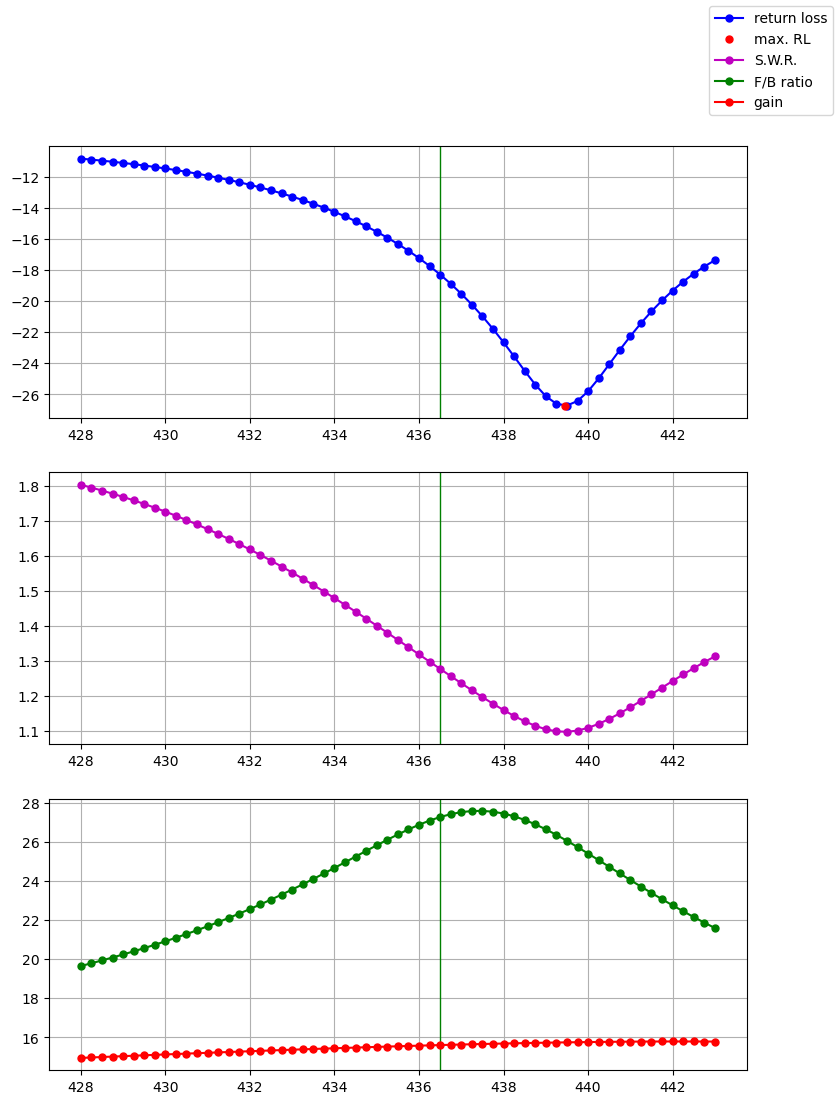

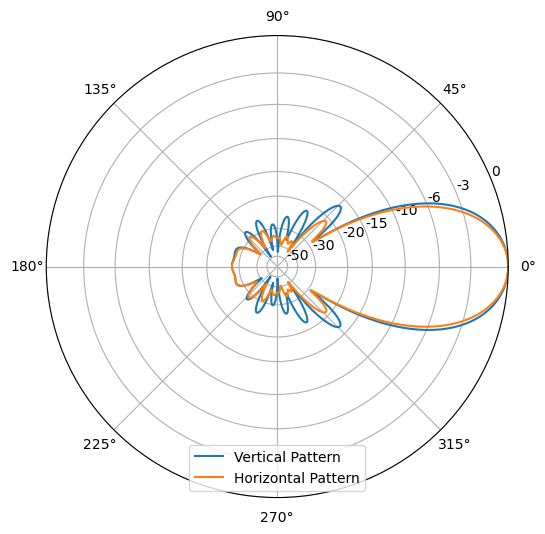

In [5]:
import random

# random errors in the range -1..1 mm
random_error = 1

def rnd():
    return (2 * random.random() - 1) * random_error * 1e-3 

nec = NecModel()
nec.load_from_file(r"C:\Ant\gtv70_13_sat.nec")

for gw in nec.gw_cards:
  if gw.radius == nec.gw_cards[0].radius:
      gw.p1 += np.array([rnd(), rnd(), rnd()])
      gw.p2 += np.array([rnd(), rnd(), rnd()])

nec.build_model
characteristics = nec.compute_characteristics()
frequencies = list_frequencies(428, 443, 0.25)
sweep = nec.sweep_frequency(frequencies)
show_model(nec, characteristics, sweep)